# Chapter 6: Feature Opportunities

**Purpose:** Identify and implement feature engineering opportunities to improve model performance.

**What you'll learn:**
- How to derive time-based features (tenure, recency, active period)
- How to create composite engagement scores
- How to segment customers based on behavior patterns
- How to encode categorical variables effectively

**Outputs:**
- Derived feature recommendations with code examples
- Composite score formulas (engagement, service adoption)
- Customer segmentation rules
- Categorical encoding strategies

---

## Why Feature Engineering Matters

| Feature Type | Business Meaning | Predictive Power |
|-------------|-----------------|------------------|
| **Tenure** | How long customer has been with us | Loyalty indicator |
| **Recency** | Days since last order | Engagement/churn signal |
| **Engagement Score** | Combined email metrics | Overall engagement level |
| **Segments** | High/Low value × Frequent/Infrequent | Risk stratification |

## 6.1 Setup

In [1]:
from customer_retention.analysis.auto_explorer import ExplorationFindings, RecommendationEngine, RecommendationRegistry
from customer_retention.analysis.visualization import ChartBuilder, display_figure, display_table
from customer_retention.core.config.column_config import ColumnType
from customer_retention.stages.features import CustomerSegmenter, SegmentationType
from customer_retention.stages.profiling import FeatureCapacityAnalyzer
import yaml
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure


In [2]:
# === CONFIGURATION ===
# Option 1: Set the exact path from notebook 01 output
# FINDINGS_PATH = "../experiments/findings/customer_retention_retail_abc123_findings.yaml"

# Option 2: Auto-discover the most recent findings file
from pathlib import Path

# FINDINGS_DIR imported from customer_retention.core.config.experiments

findings_files = [f for f in FINDINGS_DIR.glob("*_findings.yaml") if "multi_dataset" not in f.name]
if not findings_files:
    raise FileNotFoundError(f"No findings files found in {FINDINGS_DIR}. Run notebook 01 first.")

# Prefer aggregated findings (from 01d) over event-level findings
# Pattern: *_aggregated* in filename indicates aggregated data
aggregated_files = [f for f in findings_files if "_aggregated" in f.name]
non_aggregated_files = [f for f in findings_files if "_aggregated" not in f.name]

if aggregated_files:
    # Use most recent aggregated file
    aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(aggregated_files[0])
    print(f"Found {len(aggregated_files)} aggregated findings file(s)")
    print(f"Using: {FINDINGS_PATH}")
    if non_aggregated_files:
        print(f"   (Skipping {len(non_aggregated_files)} event-level findings)")
else:
    # Fall back to most recent non-aggregated file
    non_aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(non_aggregated_files[0])
    print(f"Found {len(findings_files)} findings file(s)")
    print(f"Using: {FINDINGS_PATH}")

RECOMMENDATIONS_PATH = FINDINGS_PATH.replace("_findings.yaml", "_recommendations.yaml")

findings = ExplorationFindings.load(FINDINGS_PATH)

# Load data - handle aggregated vs standard paths
from customer_retention.stages.temporal import load_data_with_snapshot_preference, TEMPORAL_METADATA_COLS

# For aggregated data, load directly from the parquet source
if "_aggregated" in FINDINGS_PATH and findings.source_path.endswith('.parquet'):
    source_path = Path(findings.source_path)
    # Handle relative path from notebook directory
    if not source_path.is_absolute():
        # The source_path in findings is relative to project root
        if str(source_path).startswith("experiments"):
            source_path = Path("..") / source_path
        else:
            source_path = FINDINGS_DIR / source_path.name
    df = pd.read_parquet(source_path)
    data_source = f"aggregated:{source_path.name}"
else:
    # Standard loading for event-level or entity-level data
    df, data_source = load_data_with_snapshot_preference(findings, output_dir=str(FINDINGS_DIR))

charts = ChartBuilder()

if Path(RECOMMENDATIONS_PATH).exists():
    with open(RECOMMENDATIONS_PATH, "r") as f:
        registry = RecommendationRegistry.from_dict(yaml.safe_load(f))
    print(f"Loaded existing recommendations: {len(registry.all_recommendations)} total")
else:
    registry = RecommendationRegistry()
    print("Initialized new recommendation registry")

# Ensure all layers are initialized (even if loaded from file)
if not registry.bronze:
    registry.init_bronze(findings.source_path)
if not registry.silver:
    registry.init_silver(findings.entity_column or "entity_id")
if not registry.gold:
    registry.init_gold(findings.target_column or "target")
    print("  Initialized gold layer for feature engineering recommendations")

print(f"\nLoaded {len(df):,} rows from: {data_source}")

Found 1 aggregated findings file(s)
Using: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_findings.yaml
   (Skipping 1 event-level findings)


Loaded existing recommendations: 299 total

Loaded 4,998 rows from: aggregated:customer_emails_408768_aggregated.parquet


## 6.2 Automated Feature Recommendations

In [3]:
recommender = RecommendationEngine()
feature_recs = recommender.recommend_features(findings)

print(f"Found {len(feature_recs)} feature engineering opportunities:\n")

for rec in feature_recs:
    print(f"{rec.feature_name}")
    print(f"  Source: {rec.source_column}")
    print(f"  Type: {rec.feature_type}")
    print(f"  Priority: {rec.priority}")
    print(f"  Description: {rec.description}")
    print()

Found 112 feature engineering opportunities:

event_count_180d_binned
  Source: event_count_180d
  Type: numeric
  Priority: low
  Description: Binned version of event_count_180d

event_count_180d_log
  Source: event_count_180d
  Type: numeric
  Priority: high
  Description: Log transform of event_count_180d (high skewness)

event_count_365d_binned
  Source: event_count_365d
  Type: numeric
  Priority: low
  Description: Binned version of event_count_365d

event_count_365d_log
  Source: event_count_365d
  Type: numeric
  Priority: high
  Description: Log transform of event_count_365d (high skewness)

event_count_all_time_binned
  Source: event_count_all_time
  Type: numeric
  Priority: low
  Description: Binned version of event_count_all_time

event_count_all_time_log
  Source: event_count_all_time
  Type: numeric
  Priority: high
  Description: Log transform of event_count_all_time (high skewness)

opened_sum_180d_binned
  Source: opened_sum_180d
  Type: numeric
  Priority: low
  Desc

## 6.3 Feature Capacity Analysis

**📖 Understanding Feature-to-Data Ratios**

Before creating new features, it's critical to understand how many features your data can reliably support. This analysis uses the **Events Per Variable (EPV)** principle:

| EPV Level | Risk Level | Recommendations |
|-----------|------------|-----------------|
| **EPV ≥ 20** | Low risk | Stable coefficients, reliable inference |
| **EPV = 10-20** | Moderate | Standard practice, consider regularization |
| **EPV = 5-10** | Elevated | Strong regularization required (L1/Lasso) |
| **EPV < 5** | High risk | Reduce features or collect more data |

**Key Assumptions:**
1. **Minority class drives capacity**: For classification, the smaller class limits feature count
2. **Correlated features are redundant**: Highly correlated features (r > 0.8) count as ~1 effective feature
3. **Model type matters**: Tree models are more flexible than linear models
4. **Regularization helps**: L1/L2 penalties allow more features with less data

**📊 What This Analysis Provides:**
- Recommended feature counts (conservative/moderate/aggressive)
- Effective feature count after removing redundancy
- Model complexity guidance (linear vs tree-based)
- Segment-specific capacity for multi-model strategies

In [4]:
# Feature Capacity Analysis
capacity_analyzer = FeatureCapacityAnalyzer()

# Get all potential feature columns (excluding target and identifiers)
feature_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [
        ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE,
        ColumnType.CATEGORICAL_NOMINAL, ColumnType.CATEGORICAL_ORDINAL,
        ColumnType.BINARY
    ] and name != findings.target_column
    and name not in TEMPORAL_METADATA_COLS
]

print("=" * 80)
print("FEATURE CAPACITY ANALYSIS")
print("=" * 80)

if findings.target_column:
    # Analyze capacity with current features
    numeric_features = [
        name for name, col in findings.columns.items()
        if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
        and name != findings.target_column
    ]
    
    capacity_result = capacity_analyzer.analyze(
        df,
        feature_cols=numeric_features,
        target_col=findings.target_column,
    )
    
    print(f"\n📊 DATA SUMMARY:")
    print(f"   Total samples: {capacity_result.total_samples:,}")
    print(f"   Minority class samples: {capacity_result.minority_class_samples:,}")
    print(f"   Minority class rate: {capacity_result.minority_class_samples/capacity_result.total_samples:.1%}")
    print(f"   Current numeric features: {capacity_result.total_features}")
    
    print(f"\n📈 FEATURE CAPACITY METRICS:")
    print(f"   Events Per Variable (EPV): {capacity_result.events_per_variable:.1f}")
    print(f"   Samples Per Feature: {capacity_result.samples_per_feature:.1f}")
    print(f"   Capacity Status: {capacity_result.capacity_status.upper()}")
    
    # Capacity status visualization
    status_colors = {"adequate": "#2ecc71", "limited": "#f39c12", "inadequate": "#e74c3c"}
    status_color = status_colors.get(capacity_result.capacity_status, "#95a5a6")
    
    print(f"\n🎯 RECOMMENDED FEATURE COUNTS:")
    print(f"   Conservative (EPV=20): {capacity_result.recommended_features_conservative} features")
    print(f"   Moderate (EPV=10):     {capacity_result.recommended_features_moderate} features")
    print(f"   Aggressive (EPV=5):    {capacity_result.recommended_features_aggressive} features")
    
    # Effective features analysis
    if capacity_result.effective_features_result:
        eff = capacity_result.effective_features_result
        print(f"\n🔍 EFFECTIVE FEATURES (accounting for correlation):")
        print(f"   Total features analyzed: {eff.total_count}")
        print(f"   Effective independent features: {eff.effective_count:.1f}")
        print(f"   Redundant features identified: {len(eff.redundant_features)}")
        
        if eff.redundant_features:
            print(f"\n   ⚠️ Redundant features (highly correlated):")
            for feat in eff.redundant_features[:5]:
                print(f"      • {feat}")
        
        if eff.feature_clusters:
            print(f"\n   📦 Correlated feature clusters ({len(eff.feature_clusters)}):")
            for i, cluster in enumerate(eff.feature_clusters[:3]):
                print(f"      Cluster {i+1}: {', '.join(cluster[:4])}")
                if len(cluster) > 4:
                    print(f"                  ... and {len(cluster)-4} more")
    
    # Persist feature capacity to registry
    registry.add_bronze_feature_capacity(
        epv=capacity_result.events_per_variable,
        capacity_status=capacity_result.capacity_status,
        recommended_features=capacity_result.recommended_features_moderate,
        current_features=capacity_result.total_features,
        rationale=f"EPV={capacity_result.events_per_variable:.1f}, status={capacity_result.capacity_status}",
        source_notebook="06_feature_opportunities"
    )
    print(f"\n✅ Persisted feature capacity recommendation to registry")
    
    # Store capacity info in findings
    findings.metadata["feature_capacity"] = capacity_result.to_dict()
else:
    print("\n⚠️ No target column detected. Capacity analysis requires a target variable.")

FEATURE CAPACITY ANALYSIS

📊 DATA SUMMARY:
   Total samples: 4,998
   Minority class samples: 1,964
   Minority class rate: 39.3%
   Current numeric features: 59

📈 FEATURE CAPACITY METRICS:
   Events Per Variable (EPV): 33.3
   Samples Per Feature: 84.7
   Capacity Status: ADEQUATE

🎯 RECOMMENDED FEATURE COUNTS:
   Conservative (EPV=20): 98 features
   Moderate (EPV=10):     196 features
   Aggressive (EPV=5):    392 features

🔍 EFFECTIVE FEATURES (accounting for correlation):
   Total features analyzed: 59
   Effective independent features: 18.0
   Redundant features identified: 29

   ⚠️ Redundant features (highly correlated):
      • bounced_count_180d
      • opened_mean_180d
      • send_hour_sum_180d
      • send_hour_count_180d
      • send_hour_count_all_time

   📦 Correlated feature clusters (12):
      Cluster 1: event_count_180d, event_count_365d, opened_count_180d, clicked_count_180d
                  ... and 7 more
      Cluster 2: event_count_all_time, opened_count_all_t

### 6.3.1 Model Complexity Guidance

Based on your data capacity, here's guidance on model complexity and feature limits.

MODEL COMPLEXITY GUIDANCE


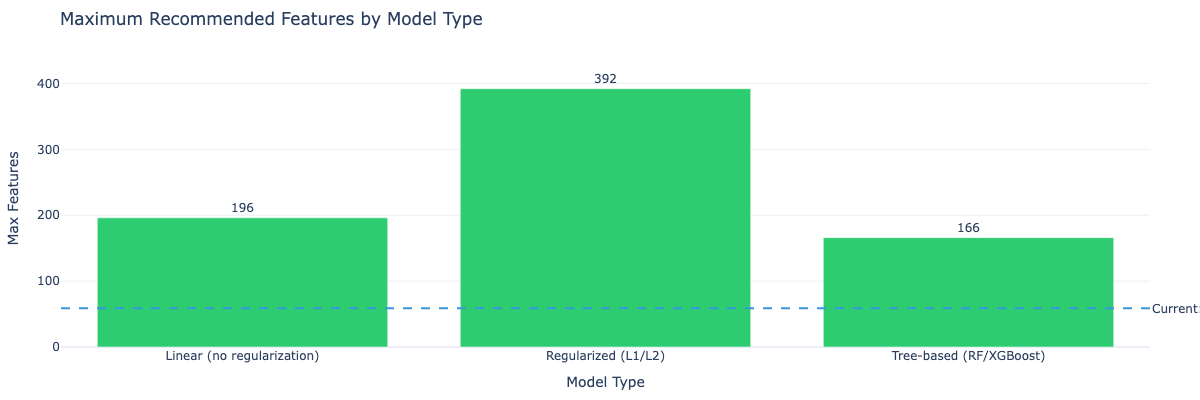


🎯 RECOMMENDED MODEL TYPE: Linear

📋 MODEL-SPECIFIC RECOMMENDATIONS:
   • Adequate data for standard logistic regression
   • Can use all features without regularization
   • Consider tree models for comparison

💡 GENERAL GUIDANCE:
   Adequate: EPV=33.3. Sufficient data for robust modeling.

----------------------------------------------------------------------
FEATURE BUDGET SUMMARY:
----------------------------------------------------------------------


,Model Type,Max Features,Current,Status
0,Linear (no regularization),196,59,✅ OK
1,Regularized (L1/L2),392,59,✅ OK
2,Tree-based,166,59,✅ OK



✅ Persisted model type recommendation to registry: linear


In [5]:
# Model Complexity Guidance
if findings.target_column and 'capacity_result' in dir():
    guidance = capacity_result.complexity_guidance
    
    print("=" * 70)
    print("MODEL COMPLEXITY GUIDANCE")
    print("=" * 70)
    
    # Create visualization of feature limits by model type
    model_types = ["Linear\n(no regularization)", "Regularized\n(L1/L2)", "Tree-based\n(RF/XGBoost)"]
    max_features = [guidance.max_features_linear, guidance.max_features_regularized, guidance.max_features_tree]
    current_features = capacity_result.total_features
    
    colors = ['#e74c3c' if m < current_features else '#2ecc71' for m in max_features]
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=model_types,
        y=max_features,
        marker_color=colors,
        text=[f"{m}" for m in max_features],
        textposition='outside',
        name='Max Features'
    ))
    
    # Add horizontal line for current feature count
    fig.add_hline(
        y=current_features,
        line_dash="dash",
        line_color="#3498db",
        annotation_text=f"Current: {current_features}",
        annotation_position="right"
    )
    
    # Calculate y-axis range to fit labels
    max_val = max(max_features)
    fig.update_layout(
        title="Maximum Recommended Features by Model Type",
        xaxis_title="Model Type",
        yaxis_title="Max Features",
        yaxis_range=[0, max_val * 1.15],  # Add 15% headroom for labels
        template='plotly_white',
        height=400,
        showlegend=False,
    )
    
    display_figure(fig)
    
    print(f"\n🎯 RECOMMENDED MODEL TYPE: {guidance.recommended_model_type.replace('_', ' ').title()}")
    
    print("\n📋 MODEL-SPECIFIC RECOMMENDATIONS:")
    for rec in guidance.model_recommendations:
        print(f"   • {rec}")
    
    print("\n💡 GENERAL GUIDANCE:")
    for rec in guidance.recommendations:
        print(f"   {rec}")
    
    # Summary table
    print("\n" + "-" * 70)
    print("FEATURE BUDGET SUMMARY:")
    print("-" * 70)
    summary_data = {
        "Model Type": ["Linear (no regularization)", "Regularized (L1/L2)", "Tree-based"],
        "Max Features": [guidance.max_features_linear, guidance.max_features_regularized, guidance.max_features_tree],
        "Current": [current_features] * 3,
        "Status": [
            "✅ OK" if guidance.max_features_linear >= current_features else "⚠️ Reduce",
            "✅ OK" if guidance.max_features_regularized >= current_features else "⚠️ Reduce", 
            "✅ OK" if guidance.max_features_tree >= current_features else "⚠️ Reduce"
        ]
    }
    display(pd.DataFrame(summary_data))
    
    # Persist model type recommendation to registry
    registry.add_bronze_model_type(
        model_type=guidance.recommended_model_type,
        max_features_linear=guidance.max_features_linear,
        max_features_regularized=guidance.max_features_regularized,
        max_features_tree=guidance.max_features_tree,
        rationale=f"Recommended: {guidance.recommended_model_type}",
        source_notebook="06_feature_opportunities"
    )
    print(f"\n✅ Persisted model type recommendation to registry: {guidance.recommended_model_type}")

### 6.3.2 Segment-Specific Capacity (for Multi-Model Strategy)

When considering **separate models per customer segment**, each segment must have sufficient data to support the feature set. This analysis shows whether segmented modeling is viable.

**📖 Single Model vs Segment Models:**

| Approach | When to Use | Pros | Cons |
|----------|------------|------|------|
| **Single Model** | Small data, uniform segments | More data per model, simpler | May miss segment-specific patterns |
| **Segment Models** | Large data, distinct segments | Tailored patterns | Need sufficient data per segment |
| **Hybrid** | Mixed segment sizes | Best of both | More complex to maintain |

SEGMENT CAPACITY ANALYSIS

📊 Analyzing segments by: lifecycle_quadrant
   Features to evaluate: 59



🎯 RECOMMENDED STRATEGY: Single Model
   Reason: No segments have adequate data for separate models.


,Segment,Samples,Minority Events,EPV,Max Features (EPV=10),Status
3,Occasional & Loyal,1632,128,2.2,12,Inadequate
0,Intense & Brief,1627,363,6.2,36,Limited
2,Steady & Loyal,872,60,1.0,6,Inadequate
1,One-shot,867,355,6.0,35,Limited


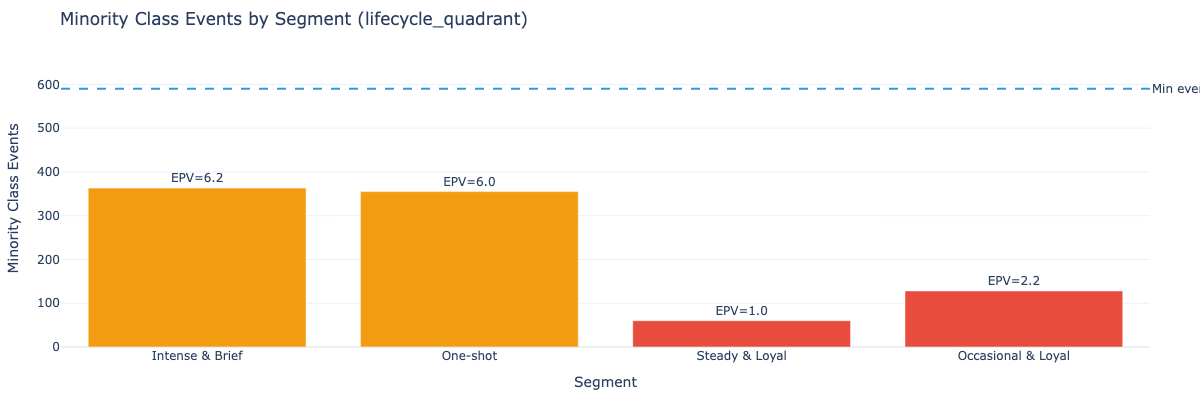


📋 SEGMENT RECOMMENDATIONS:
   Small segments (Intense & Brief, One-shot, Steady & Loyal, Occasional & Loyal) have 906 total events.
   Use a single model with segment as a feature for stratification.
   ⚠️ Insufficient data: Intense & Brief, One-shot, Steady & Loyal, Occasional & Loyal


In [6]:
# Segment Capacity Analysis
categorical_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.CATEGORICAL_NOMINAL, ColumnType.CATEGORICAL_ORDINAL]
    and name not in TEMPORAL_METADATA_COLS
]

print("=" * 70)
print("SEGMENT CAPACITY ANALYSIS")
print("=" * 70)

if findings.target_column and categorical_cols and 'numeric_features' in dir():
    # Analyze the first categorical column as potential segment
    segment_col = categorical_cols[0]
    
    print(f"\n📊 Analyzing segments by: {segment_col}")
    print(f"   Features to evaluate: {len(numeric_features)}")
    
    segment_result = capacity_analyzer.analyze_segment_capacity(
        df,
        feature_cols=numeric_features,
        target_col=findings.target_column,
        segment_col=segment_col,
    )
    
    print(f"\n🎯 RECOMMENDED STRATEGY: {segment_result.recommended_strategy.replace('_', ' ').title()}")
    print(f"   Reason: {segment_result.strategy_reason}")
    
    # Segment details table
    segment_data = []
    for seg_name, cap in segment_result.segment_capacities.items():
        segment_data.append({
            "Segment": seg_name,
            "Samples": cap.total_samples,
            "Minority Events": cap.minority_class_samples,
            "EPV": f"{cap.events_per_variable:.1f}",
            "Max Features (EPV=10)": cap.recommended_features_moderate,
            "Status": cap.capacity_status.title()
        })
    
    segment_df = pd.DataFrame(segment_data)
    segment_df = segment_df.sort_values("Samples", ascending=False)
    display(segment_df)
    
    # Visualization
    fig = go.Figure()
    
    max_events = 0
    for seg_name, cap in segment_result.segment_capacities.items():
        color = "#2ecc71" if cap.capacity_status == "adequate" else "#f39c12" if cap.capacity_status == "limited" else "#e74c3c"
        fig.add_trace(go.Bar(
            name=seg_name,
            x=[seg_name],
            y=[cap.minority_class_samples],
            marker_color=color,
            text=[f"EPV={cap.events_per_variable:.1f}"],
            textposition='outside'
        ))
        max_events = max(max_events, cap.minority_class_samples)
    
    # Add threshold line
    threshold_events = len(numeric_features) * 10  # EPV=10 threshold
    fig.add_hline(
        y=threshold_events,
        line_dash="dash",
        line_color="#3498db",
        annotation_text=f"Min events for {len(numeric_features)} features (EPV=10)",
        annotation_position="right"
    )
    
    # Calculate y-axis range to fit labels
    y_max = max(max_events, threshold_events)
    fig.update_layout(
        title=f"Minority Class Events by Segment ({segment_col})",
        xaxis_title="Segment",
        yaxis_title="Minority Class Events",
        yaxis_range=[0, y_max * 1.15],  # Add 15% headroom for labels
        template='plotly_white',
        height=400,
        showlegend=False,
    )
    display_figure(fig)
    
    print("\n📋 SEGMENT RECOMMENDATIONS:")
    for rec in segment_result.recommendations:
        print(f"   {rec}")
    
    if segment_result.viable_segments:
        print(f"\n   ✅ Viable for separate models: {', '.join(segment_result.viable_segments)}")
    if segment_result.insufficient_segments:
        print(f"   ⚠️ Insufficient data: {', '.join(segment_result.insufficient_segments)}")
    
    # Store in findings
    findings.metadata["segment_capacity"] = segment_result.to_dict()
else:
    print("\n⚠️ No categorical columns available for segment analysis.")
    print("   Segment capacity analysis requires at least one categorical column.")

### 6.3.3 Feature Capacity Action Items

Based on the analysis above, here are the key considerations for feature engineering:

In [7]:
# Feature Capacity Action Items Summary
if findings.target_column and 'capacity_result' in dir():
    print("=" * 70)
    print("FEATURE CAPACITY ACTION ITEMS")
    print("=" * 70)
    
    print("\n📋 BASED ON YOUR DATA CAPACITY:")
    
    # Action items based on capacity status
    if capacity_result.capacity_status == "adequate":
        print("\n✅ ADEQUATE CAPACITY - You have room to add features")
        print(f"   • Current features: {capacity_result.total_features}")
        print(f"   • Can add up to: {capacity_result.recommended_features_moderate - capacity_result.total_features} more features (EPV=10)")
        print(f"   • Consider: Creating derived features from datetime and categorical columns")
    elif capacity_result.capacity_status == "limited":
        print("\n⚠️ LIMITED CAPACITY - Be selective with new features")
        print(f"   • Current features: {capacity_result.total_features}")
        print(f"   • Recommended max: {capacity_result.recommended_features_moderate} features (EPV=10)")
        print(f"   • Action: Remove {max(0, capacity_result.total_features - capacity_result.recommended_features_moderate)} redundant features before adding new ones")
        print(f"   • Consider: Using regularization (L1/Lasso) if keeping all features")
    else:
        print("\n🔴 INADEQUATE CAPACITY - Reduce features or get more data")
        print(f"   • Current features: {capacity_result.total_features}")
        print(f"   • Recommended max: {capacity_result.recommended_features_moderate} features (EPV=10)")
        print(f"   • CRITICAL: Reduce to {capacity_result.recommended_features_conservative} features for stable estimates")
        print(f"   • Options: (1) Feature selection, (2) PCA, (3) Collect more data")
    
    # Redundancy recommendations
    if capacity_result.effective_features_result and capacity_result.effective_features_result.redundant_features:
        redundant = capacity_result.effective_features_result.redundant_features
        print(f"\n🔄 REDUNDANT FEATURES TO CONSIDER REMOVING:")
        print(f"   These features are highly correlated with others and add little new information:")
        for feat in redundant[:5]:
            print(f"   • {feat}")
        if len(redundant) > 5:
            print(f"   ... and {len(redundant) - 5} more")
    
    # New feature budget
    print("\n💰 FEATURE BUDGET FOR NEW FEATURES:")
    remaining_budget = capacity_result.recommended_features_moderate - capacity_result.total_features
    if remaining_budget > 0:
        print(f"   You can safely add {remaining_budget} new features")
        print("   Prioritize:")
        print("   • Recency features (days_since_last_activity)")
        print("   • Tenure features (days_since_created)")
        print("   • Engagement composites (email_engagement_score)")
    else:
        print(f"   ⚠️ At or over capacity. Remove {-remaining_budget} features before adding new ones.")
    
    # Model selection summary
    print("\n🎯 RECOMMENDED MODELING APPROACH:")
    if capacity_result.complexity_guidance:
        print(f"   Model type: {capacity_result.complexity_guidance.recommended_model_type.replace('_', ' ').title()}")
        if "regularized" in capacity_result.complexity_guidance.recommended_model_type:
            print("   → Use Lasso (L1) for automatic feature selection")
            print("   → Use Ridge (L2) if you want to keep all features")
        elif "tree" in capacity_result.complexity_guidance.recommended_model_type:
            print("   → Random Forest or XGBoost recommended")
            print("   → Trees handle correlated features naturally")
    
    print("\n" + "=" * 70)

FEATURE CAPACITY ACTION ITEMS

📋 BASED ON YOUR DATA CAPACITY:

✅ ADEQUATE CAPACITY - You have room to add features
   • Current features: 59
   • Can add up to: 137 more features (EPV=10)
   • Consider: Creating derived features from datetime and categorical columns

🔄 REDUNDANT FEATURES TO CONSIDER REMOVING:
   These features are highly correlated with others and add little new information:
   • bounced_count_180d
   • opened_mean_180d
   • send_hour_sum_180d
   • send_hour_count_180d
   • send_hour_count_all_time
   ... and 24 more

💰 FEATURE BUDGET FOR NEW FEATURES:
   You can safely add 137 new features
   Prioritize:
   • Recency features (days_since_last_activity)
   • Tenure features (days_since_created)
   • Engagement composites (email_engagement_score)

🎯 RECOMMENDED MODELING APPROACH:
   Model type: Linear



### 6.3.4 Feature Availability Issues

Features with tracking changes (new systems, retired systems) require special handling before modeling.

In [8]:
# Feature Availability Analysis
from customer_retention.stages.features.feature_selector import FeatureSelector

print("=" * 70)
print("FEATURE AVAILABILITY ANALYSIS")
print("=" * 70)

unavailable_features = []
if findings.has_availability_issues:
    selector = FeatureSelector(target_column=findings.target_column)
    availability_recs = selector.get_availability_recommendations(findings.feature_availability)
    unavailable_features = [rec.column for rec in availability_recs]
    
    print(f"\n⚠️  {len(availability_recs)} feature(s) have tracking changes:\n")
    
    for rec in availability_recs:
        print(f"📌 {rec.column}")
        print(f"   Issue: {rec.issue_type} | Coverage: {rec.coverage_pct:.0f}%")
        print(f"   Available: {rec.first_valid_date} → {rec.last_valid_date}")
        print(f"\n   Remediation options:")
        for opt in rec.options:
            marker = "→" if opt.get("recommended") else " "
            print(f"   {marker} [{opt['type']}] {opt['description']}")
        print()
    
    print("-" * 70)
    print("RECOMMENDED ACTION: Remove unavailable features before modeling")
    print("-" * 70)
    print(f"\nFeatures to exclude: {', '.join(unavailable_features)}")
    print("\nAlternative approaches (require additional implementation):")
    print("  • segment_by_cohort: Train separate models for different time periods")
    print("  • add_indicator: Create availability flags, impute missing values")
    print("  • filter_window: Restrict training data to feature's available period")
    
    findings.metadata["unavailable_features"] = unavailable_features
    findings.metadata["availability_action"] = "exclude"
else:
    print("\n✅ All features have full temporal coverage - no availability issues.")

FEATURE AVAILABILITY ANALYSIS

✅ All features have full temporal coverage - no availability issues.


## 6.4 Datetime Feature Opportunities

In [9]:
datetime_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type == ColumnType.DATETIME
]

if datetime_cols:
    print("Datetime Feature Opportunities:")
    print("="*50)
    for col in datetime_cols:
        print(f"\n{col}:")
        print(f"  - {col}_year: Extract year")
        print(f"  - {col}_month: Extract month")
        print(f"  - {col}_day: Extract day of month")
        print(f"  - {col}_dayofweek: Extract day of week (0-6)")
        print(f"  - {col}_is_weekend: Is weekend flag")
        print(f"  - days_since_{col}: Days since date")
else:
    print("No datetime columns found.")

No datetime columns found.


## 6.5 Business-Driven Derived Features

These features are based on domain knowledge from the reference analysis (my_take Phase 1).

**📖 Key Derived Features:**
- **Tenure Days**: Days from account creation to analysis date
- **Days Since Last Order**: Recency indicator (critical for churn)
- **Active Period Days**: Duration of customer activity
- **Email Engagement Score**: Composite of open rate and click rate
- **Click-to-Open Ratio**: Quality of email engagement
- **Service Adoption Score**: Sum of service flags (paperless, refill, doorstep)

In [10]:
print("=" * 70)
print("CREATING DERIVED FEATURES")
print("=" * 70)

segmenter = CustomerSegmenter()
df_features = df.copy()

datetime_cols = [name for name, col in findings.columns.items() 
                 if col.inferred_type == ColumnType.DATETIME
                 and name not in TEMPORAL_METADATA_COLS]
binary_cols = [name for name, col in findings.columns.items() 
               if col.inferred_type == ColumnType.BINARY
               and name not in TEMPORAL_METADATA_COLS]
numeric_cols = [name for name, col in findings.columns.items() 
                if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]]

for col in datetime_cols:
    df_features[col] = pd.to_datetime(df_features[col], errors='coerce', format='mixed')

reference_date = pd.Timestamp.now()
if datetime_cols:
    last_dates = [df_features[col].max() for col in datetime_cols if df_features[col].notna().any()]
    if last_dates:
        reference_date = max(last_dates)
print(f"\nReference date: {reference_date}")

print("\n📅 TIME-BASED FEATURES:")
created_cols = [c for c in datetime_cols if 'creat' in c.lower() or 'signup' in c.lower() or 'register' in c.lower()]
if created_cols:
    created_col = created_cols[0]
    df_features = segmenter.create_tenure_features(df_features, created_column=created_col, reference_date=reference_date)
    print(f"  ✓ tenure_days from {created_col}")
    registry.add_silver_derived(
        column="tenure_days",
        expression=f"(reference_date - {created_col}).days",
        feature_type="tenure",
        rationale=f"Customer tenure in days from {created_col}",
        source_notebook="06_feature_opportunities"
    )

activity_cols = [c for c in datetime_cols if 'last' in c.lower() or 'recent' in c.lower()]
if activity_cols:
    activity_col = activity_cols[0]
    df_features = segmenter.create_recency_features(df_features, last_activity_column=activity_col, 
                                                     reference_date=reference_date, output_column='days_since_last_activity')
    print(f"  ✓ days_since_last_activity from {activity_col}")
    registry.add_silver_derived(
        column="days_since_last_activity",
        expression=f"(reference_date - {activity_col}).days",
        feature_type="recency",
        rationale=f"Days since last activity from {activity_col}",
        source_notebook="06_feature_opportunities"
    )

print("\n📧 ENGAGEMENT FEATURES:")
rate_cols = [c for c in numeric_cols if 'rate' in c.lower() or 'pct' in c.lower() or 'percent' in c.lower()]
open_rate_cols = [c for c in rate_cols if 'open' in c.lower()]
click_rate_cols = [c for c in rate_cols if 'click' in c.lower()]

if open_rate_cols and click_rate_cols:
    open_col, click_col = open_rate_cols[0], click_rate_cols[0]
    df_features = segmenter.create_engagement_score(df_features, open_rate_column=open_col, 
                                                     click_rate_column=click_col, output_column='email_engagement_score')
    print(f"  ✓ email_engagement_score from {open_col}, {click_col}")
    registry.add_silver_derived(
        column="email_engagement_score",
        expression=f"0.6 * {open_col} + 0.4 * {click_col}",
        feature_type="composite",
        rationale=f"Weighted engagement score from {open_col} and {click_col}",
        source_notebook="06_feature_opportunities"
    )
    
    df_features['click_to_open_rate'] = np.where(df_features[open_col] > 0, df_features[click_col] / df_features[open_col], 0)
    print(f"  ✓ click_to_open_rate")
    registry.add_silver_ratio(
        column="click_to_open_rate",
        numerator=click_col,
        denominator=open_col,
        rationale=f"Click-to-open ratio: {click_col} / {open_col}",
        source_notebook="06_feature_opportunities"
    )

print("\n🔧 SERVICE ADOPTION:")
if binary_cols:
    service_binary = [c for c in binary_cols if c != findings.target_column]
    if service_binary:
        df_features['service_adoption_score'] = df_features[service_binary].sum(axis=1)
        print(f"  ✓ service_adoption_score from {service_binary}")
        registry.add_silver_derived(
            column="service_adoption_score",
            expression=f"sum([{', '.join(service_binary)}])",
            feature_type="composite",
            rationale=f"Service adoption count from {len(service_binary)} binary flags",
            source_notebook="06_feature_opportunities"
        )

print("\n💰 VALUE FEATURES:")
value_cols = [c for c in numeric_cols if 'order' in c.lower() or 'amount' in c.lower() or 'value' in c.lower() or 'avg' in c.lower()]
freq_cols = [c for c in numeric_cols if 'freq' in c.lower() or 'count' in c.lower()]
if value_cols and freq_cols:
    df_features['value_frequency_product'] = df_features[value_cols[0]] * df_features[freq_cols[0]]
    print(f"  ✓ value_frequency_product from {value_cols[0]}, {freq_cols[0]}")
    registry.add_silver_interaction(
        column="value_frequency_product",
        features=[value_cols[0], freq_cols[0]],
        rationale=f"Value-frequency interaction: {value_cols[0]} × {freq_cols[0]}",
        source_notebook="06_feature_opportunities"
    )

new_cols = len(df_features.columns) - len(df.columns)
print(f"\n✓ Created {new_cols} new features (total: {len(df_features.columns)})")
print(f"✅ Persisted {len([c for c in ['tenure_days', 'days_since_last_activity', 'email_engagement_score', 'click_to_open_rate', 'service_adoption_score', 'value_frequency_product'] if c in df_features.columns])} derived feature recommendations to registry")

CREATING DERIVED FEATURES

Reference date: 2026-01-29 18:49:10.672265

📅 TIME-BASED FEATURES:

📧 ENGAGEMENT FEATURES:

🔧 SERVICE ADOPTION:
  ✓ service_adoption_score from ['opened_max_180d', 'clicked_max_180d', 'bounced_max_180d', 'opened_max_365d', 'clicked_max_365d', 'bounced_max_365d', 'opened_max_all_time', 'clicked_max_all_time', 'bounced_max_all_time']

💰 VALUE FEATURES:

✓ Created 1 new features (total: 73)
✅ Persisted 1 derived feature recommendations to registry


## 6.6 Customer Segmentation Features

Create business-meaningful segments for analysis and modeling.

**📖 Segmentation Strategy:**
- **Value Dimension**: High vs Low (based on avgorder median)
- **Frequency Dimension**: Frequent vs Infrequent (based on ordfreq median)
- **Recency Buckets**: Active, Recent, Lapsing, Dormant

In [11]:
print("=" * 70)
print("CUSTOMER SEGMENTATION")
print("=" * 70)

print("\n🎯 VALUE-FREQUENCY SEGMENTS:")
value_cols = [c for c in numeric_cols if 'order' in c.lower() or 'amount' in c.lower() or 'value' in c.lower() or 'avg' in c.lower()]
freq_cols = [c for c in numeric_cols if 'freq' in c.lower() or 'count' in c.lower()]

if value_cols and freq_cols:
    df_features, vf_result = segmenter.segment_by_value_frequency(
        df_features, value_column=value_cols[0], frequency_column=freq_cols[0])
    print(f"  Using {value_cols[0]} × {freq_cols[0]}")
    for seg in vf_result.segments:
        print(f"    {seg.name}: {seg.count:,} ({seg.percentage:.1f}%)")
else:
    print("  No suitable value/frequency columns found")

print("\n📅 RECENCY SEGMENTS:")
if 'days_since_last_activity' in df_features.columns:
    df_features, recency_result = segmenter.segment_by_recency(df_features, days_since_column='days_since_last_activity')
    for seg in recency_result.segments:
        print(f"    {seg.name}: {seg.count:,} ({seg.percentage:.1f}%)")
else:
    print("  No recency column available")

print("\n📧 ENGAGEMENT SEGMENTS:")
if 'email_engagement_score' in df_features.columns:
    max_score = df_features['email_engagement_score'].max()
    if max_score > 0:
        df_features['engagement_normalized'] = df_features['email_engagement_score'] / max_score
        df_features, eng_result = segmenter.segment_by_engagement(df_features, engagement_column='engagement_normalized')
        for seg in eng_result.segments:
            print(f"    {seg.name}: {seg.count:,} ({seg.percentage:.1f}%)")
        df_features = df_features.drop(columns=['engagement_normalized'])
else:
    print("  No engagement score available")

if 'customer_segment' in df_features.columns and findings.target_column and findings.target_column in df_features.columns:
    target = findings.target_column
    segment_retention = df_features.groupby('customer_segment')[target].mean() * 100
    
    max_rate = segment_retention.max()
    fig = go.Figure(go.Bar(
        x=segment_retention.index, y=segment_retention.values,
        marker_color=['#2ca02c' if r > 70 else '#ffbb00' if r > 50 else '#d62728' for r in segment_retention.values],
        text=[f'{r:.1f}%' for r in segment_retention.values], textposition='outside'))
    fig.update_layout(
        title='Retention Rate by Customer Segment', 
        xaxis_title='Segment', 
        yaxis_title='Retention Rate (%)',
        yaxis_range=[0, max_rate * 1.15],  # Add 15% headroom for labels
        template='plotly_white', 
        height=400,
    )
    display_figure(fig)

segment_cols = [c for c in df_features.columns if 'segment' in c.lower() or 'bucket' in c.lower()]
print(f"\n✓ Created {len(segment_cols)} segmentation features")

CUSTOMER SEGMENTATION

🎯 VALUE-FREQUENCY SEGMENTS:
  No suitable value/frequency columns found

📅 RECENCY SEGMENTS:
  No recency column available

📧 ENGAGEMENT SEGMENTS:
  No engagement score available

✓ Created 1 segmentation features


## 6.7 Numeric Transformation Opportunities

In [12]:
numeric_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
    and name not in TEMPORAL_METADATA_COLS
]

transform_count = 0
if numeric_cols:
    print("Numeric Transformation Opportunities:")
    print("="*50)
    
    for col_name in numeric_cols:
        col_info = findings.columns[col_name]
        series = df[col_name].dropna()
        skewness = series.skew()
        
        print(f"\n{col_name}:")
        print(f"  Skewness: {skewness:.2f}")
        
        if abs(skewness) > 1:
            print(f"  Recommendation: Apply log transform (highly skewed)")
            registry.add_gold_transformation(
                column=col_name,
                transform="log",
                parameters={"skewness": float(skewness), "reason": "highly_skewed"},
                rationale=f"Log transform for highly skewed distribution (skewness={skewness:.2f})",
                source_notebook="06_feature_opportunities"
            )
            transform_count += 1
        elif abs(skewness) > 0.5:
            print(f"  Recommendation: Consider sqrt transform (moderately skewed)")
            registry.add_gold_transformation(
                column=col_name,
                transform="sqrt",
                parameters={"skewness": float(skewness), "reason": "moderately_skewed"},
                rationale=f"Sqrt transform for moderately skewed distribution (skewness={skewness:.2f})",
                source_notebook="06_feature_opportunities"
            )
            transform_count += 1
        else:
            print(f"  Recommendation: Standard scaling sufficient")
            registry.add_gold_scaling(
                column=col_name,
                method="standard",
                rationale=f"Standard scaling for normally distributed column (skewness={skewness:.2f})",
                source_notebook="06_feature_opportunities"
            )
            transform_count += 1
        
        if col_info.inferred_type == ColumnType.NUMERIC_CONTINUOUS:
            print(f"  Binning: Consider creating bins for {col_name}_binned")
    
    print(f"\n✅ Persisted {transform_count} transformation recommendations to registry")

Numeric Transformation Opportunities:

event_count_180d:
  Skewness: 2.13
  Recommendation: Apply log transform (highly skewed)

event_count_365d:
  Skewness: 1.93
  Recommendation: Apply log transform (highly skewed)

event_count_all_time:
  Skewness: 2.90
  Recommendation: Apply log transform (highly skewed)
  Binning: Consider creating bins for event_count_all_time_binned

opened_sum_180d:
  Skewness: 3.31
  Recommendation: Apply log transform (highly skewed)

opened_mean_180d:
  Skewness: 1.35
  Recommendation: Apply log transform (highly skewed)

opened_count_180d:
  Skewness: 2.13
  Recommendation: Apply log transform (highly skewed)

clicked_sum_180d:
  Skewness: 4.76
  Recommendation: Apply log transform (highly skewed)

clicked_mean_180d:
  Skewness: 3.45
  Recommendation: Apply log transform (highly skewed)

clicked_count_180d:
  Skewness: 2.13
  Recommendation: Apply log transform (highly skewed)

send_hour_sum_180d:
  Skewness: 2.25
  Recommendation: Apply log transform (hi


bounced_count_all_time:
  Skewness: 2.90
  Recommendation: Apply log transform (highly skewed)
  Binning: Consider creating bins for bounced_count_all_time_binned

time_to_open_hours_sum_all_time:
  Skewness: 2.31
  Recommendation: Apply log transform (highly skewed)
  Binning: Consider creating bins for time_to_open_hours_sum_all_time_binned

time_to_open_hours_mean_all_time:
  Skewness: 1.97
  Recommendation: Apply log transform (highly skewed)
  Binning: Consider creating bins for time_to_open_hours_mean_all_time_binned

time_to_open_hours_max_all_time:
  Skewness: 1.32
  Recommendation: Apply log transform (highly skewed)
  Binning: Consider creating bins for time_to_open_hours_max_all_time_binned

time_to_open_hours_count_all_time:
  Skewness: 2.32
  Recommendation: Apply log transform (highly skewed)
  Binning: Consider creating bins for time_to_open_hours_count_all_time_binned

days_since_last_event:
  Skewness: 1.22
  Recommendation: Apply log transform (highly skewed)
  Binni

## 6.8 Categorical Encoding Opportunities

In [13]:
categorical_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.CATEGORICAL_NOMINAL, ColumnType.CATEGORICAL_ORDINAL]
    and name not in TEMPORAL_METADATA_COLS
]

encoding_count = 0
if categorical_cols:
    print("Categorical Encoding Recommendations:")
    print("="*50)
    
    for col_name in categorical_cols:
        col_info = findings.columns[col_name]
        distinct = col_info.universal_metrics.get("distinct_count", 0)
        
        print(f"\n{col_name}: ({distinct} unique values)")
        
        if distinct <= 5:
            print(f"  Recommendation: One-hot encoding")
            registry.add_gold_encoding(
                column=col_name,
                method="onehot",
                rationale=f"One-hot encoding for low cardinality ({distinct} unique values)",
                source_notebook="06_feature_opportunities"
            )
            encoding_count += 1
        elif distinct <= 20:
            print(f"  Recommendation: Target encoding or one-hot with frequency threshold")
            registry.add_gold_encoding(
                column=col_name,
                method="target",
                rationale=f"Target encoding for medium cardinality ({distinct} unique values)",
                source_notebook="06_feature_opportunities"
            )
            encoding_count += 1
        else:
            print(f"  Recommendation: Target encoding or embedding (high cardinality)")
            registry.add_gold_encoding(
                column=col_name,
                method="target",
                rationale=f"Target encoding for high cardinality ({distinct} unique values)",
                source_notebook="06_feature_opportunities"
            )
            encoding_count += 1
        
        if col_info.inferred_type == ColumnType.CATEGORICAL_ORDINAL:
            print(f"  Note: Consider ordinal encoding to preserve order")
    
    print(f"\n✅ Persisted {encoding_count} encoding recommendations to registry")

Categorical Encoding Recommendations:

lifecycle_quadrant: (4 unique values)
  Recommendation: One-hot encoding

recency_bucket: (5 unique values)
  Recommendation: One-hot encoding

✅ Persisted 2 encoding recommendations to registry


---

## Summary: What We Learned

In this notebook, we identified feature engineering opportunities and analyzed data capacity:

### Feature Capacity Analysis
1. **Events Per Variable (EPV)** - Calculated the data's capacity to support features
2. **Effective Features** - Identified redundant features due to high correlation
3. **Model Complexity Guidance** - Determined appropriate model types based on data size
4. **Segment Capacity** - Evaluated whether segmented modeling is viable

### Feature Engineering
5. **Automated Recommendations** - Framework suggested feature opportunities
6. **Time-Based Features** - Created tenure, recency, active period metrics
7. **Engagement Scores** - Built composite email engagement metrics
8. **Customer Segments** - Created value-frequency and recency-based segments
9. **Encoding Strategies** - Identified optimal encoding for each categorical

## Feature Capacity Key Concepts

| Metric | What It Means | Rule of Thumb |
|--------|---------------|---------------|
| **EPV ≥ 20** | Stable, reliable estimates | Conservative, regulatory-grade |
| **EPV = 10-20** | Standard practice | Use for most applications |
| **EPV = 5-10** | Limited capacity | Requires strong regularization |
| **EPV < 5** | High risk | Reduce features or get more data |

## Key Derived Features Created

| Feature | Formula | Business Meaning |
|---------|---------|-----------------|
| `tenure_days` | reference_date - created | Customer longevity |
| `days_since_last_order` | reference_date - lastorder | Recency/engagement |
| `email_engagement_score` | 0.6×openrate + 0.4×clickrate | Overall engagement |
| `service_adoption_score` | paperless + refill + doorstep | Service utilization |
| `customer_segment` | Value × Frequency quadrant | Customer type |

---

## Next Steps

Continue to **07_modeling_readiness.ipynb** to:
- Validate data is ready for modeling
- Check for data leakage
- Assess class imbalance
- Review feature completeness

In [14]:
print("Potential Interaction Features:")
print("="*50)

if len(numeric_cols) >= 2:
    print("\nNumeric Interactions:")
    for i, col1 in enumerate(numeric_cols[:3]):
        for col2 in numeric_cols[i+1:4]:
            print(f"  - {col1}_x_{col2}: Multiplication")
            print(f"  - {col1}_div_{col2}: Division (if {col2} > 0)")

if categorical_cols and numeric_cols:
    print("\nCategorical-Numeric Interactions:")
    for cat_col in categorical_cols[:2]:
        for num_col in numeric_cols[:2]:
            print(f"  - {num_col}_by_{cat_col}_mean: Group mean")
            print(f"  - {num_col}_by_{cat_col}_std: Group std")

Potential Interaction Features:

Numeric Interactions:
  - event_count_180d_x_event_count_365d: Multiplication
  - event_count_180d_div_event_count_365d: Division (if event_count_365d > 0)
  - event_count_180d_x_event_count_all_time: Multiplication
  - event_count_180d_div_event_count_all_time: Division (if event_count_all_time > 0)
  - event_count_180d_x_opened_sum_180d: Multiplication
  - event_count_180d_div_opened_sum_180d: Division (if opened_sum_180d > 0)
  - event_count_365d_x_event_count_all_time: Multiplication
  - event_count_365d_div_event_count_all_time: Division (if event_count_all_time > 0)
  - event_count_365d_x_opened_sum_180d: Multiplication
  - event_count_365d_div_opened_sum_180d: Division (if opened_sum_180d > 0)
  - event_count_all_time_x_opened_sum_180d: Multiplication
  - event_count_all_time_div_opened_sum_180d: Division (if opened_sum_180d > 0)

Categorical-Numeric Interactions:
  - event_count_180d_by_lifecycle_quadrant_mean: Group mean
  - event_count_180d_by

## 6.9 Feature Summary Table

In [15]:
feature_summary = []
for rec in feature_recs:
    feature_summary.append({
        "Feature Name": rec.feature_name,
        "Source": rec.source_column,
        "Type": rec.feature_type,
        "Priority": rec.priority
    })

if feature_summary:
    summary_df = pd.DataFrame(feature_summary)
    display(summary_df)

,Feature Name,Source,Type,Priority
0,event_count_180d_binned,event_count_180d,numeric,low
1,event_count_180d_log,event_count_180d,numeric,high
2,event_count_365d_binned,event_count_365d,numeric,low
3,event_count_365d_log,event_count_365d,numeric,high
4,event_count_all_time_binned,event_count_all_time,numeric,low
...,...,...,...,...
107,dow_sin_binned,dow_sin,numeric,low
108,dow_cos_binned,dow_cos,numeric,low
109,dow_cos_log,dow_cos,numeric,high
110,clicked_momentum_180_365_binned,clicked_momentum_180_365,numeric,low


---

## Next Steps

Continue to **07_modeling_readiness.ipynb** to validate data is ready for modeling.

In [16]:
# Save recommendations
with open(RECOMMENDATIONS_PATH, "w") as f:
    yaml.dump(registry.to_dict(), f, default_flow_style=False, sort_keys=False)

print(f"✅ Saved {len(registry.all_recommendations)} recommendations to {RECOMMENDATIONS_PATH}")
print(f"\nRecommendations by layer:")
for layer in ["bronze", "silver", "gold"]:
    recs = registry.get_by_layer(layer)
    print(f"  {layer.upper()}: {len(recs)}")

✅ Saved 363 recommendations to /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_recommendations.yaml

Recommendations by layer:
  BRONZE: 52
  SILVER: 8
  GOLD: 303
